In [173]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [174]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [175]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [176]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [177]:
# Config
SUB_FILE_NAME = "val10-1"
SAVE_SUB = False
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SAVE_DF = False
SAVE_DF_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/Val_20230429")

# データ読み込み

In [178]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

# 特徴抽出後のデータ
umap_basic_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_train.pkl")
umap_basic_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_test.pkl")
train_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_sentinel_minmaxDiff.pkl")
test_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_sentinel_minmaxDiff.pkl")
train_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_train_landsat2_2000to2020.pkl")
test_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_test_landsat2_2000to2020.pkl")
train_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_landsat_minmax.pkl")
test_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_landsat_minmax.pkl")

train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [179]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [180]:
train[f"log_cover"] = np.log1p(train["cover"])

## 特徴抽出後のデータを結合

In [181]:
print(train.shape)
print(train_landsat_minmax.shape)
print(test.shape)
print(test_landsat_minmax.shape)
train_landsat_minmax.head(2)

(14140, 3465)
(14140, 50)
(4039, 3463)
(4039, 50)


,MINMAX_MVI,MINMAX_Chlred_edge,MINMAX_NLI,MINMAX_IF,MINMAX_GEMI,MINMAX_Chlgreen,MINMAX_CVI,MINMAX_DSWI_5,MINMAX_TSAVI,MINMAX_PSNDc2,...,MINMAX_EVI,MINMAX_GVMI,MINMAX_RDVI,MINMAX_PPR,MINMAX_SIPI2,MINMAX_Cigreen,MINMAX_D678_500,MINMAX_DVIMSS,MINMAX_Green,MINMAX_Alteration
0,-0.498732,-0.031920,1.075848,1.225176,0.018427,0.065996,0.91124,0.839658,1.035656,1.000000,...,0.558870,0.176156,0.345818,1.035576,0.350692,0.960665,-0.223362,1.000000,1.052035,3.30233
1,0.698608,1.080161,-0.089137,-1.235533,0.525556,1.083810,-0.57457,-0.393703,-0.195017,-0.575291,...,2.011747,0.262679,-0.418989,-0.841783,0.968533,-0.482458,-0.112053,-1.535718,-0.357916,-0.12575


In [182]:
train = train.join([
    umap_basic_train,
    train_sentinel,
    train_landsat_minmax,
    train_landsat_2000to2020,
])
test = test.join([
    umap_basic_test,
    test_sentinel,
    test_landsat_minmax,
    test_landsat_2000to2020,
])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MINMAX_MCARI2__mean,MINMAX_MCARI2__std,MED_NormR_median,MED_NormR_std,MINMAX_NormR__mean,MINMAX_NormR__std,MED_TIRS2_median,MED_TIRS2_std,MINMAX_TIRS2__mean,MINMAX_TIRS2__std
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-0.006201,1.087738,0.222131,0.699859,-0.086431,1.010979,0.470200,0.632177,-0.219153,0.892955
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,-0.775479,0.251864,0.904064,1.205264,-0.222484,0.889441,-0.002017,0.795383,-0.719698,0.899809


In [183]:
umap_basic_train.head()

,dim0,dim1,temp_monthly
0,1.788618,6.597842,27.9
1,-10.111396,6.170877,29.2
2,21.165592,6.679852,25.3
3,-6.996612,9.728025,16.7
4,-6.822807,9.109682,16.7


## 使用する特徴量

In [184]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
cols_landsat = train.columns.to_list()[25:88]
cols_landsat_2000to2020 = train_landsat_2000to2020.columns.to_list()
cols_landsat_minmax = train_landsat_minmax.columns.to_list()

cols_sentinel = train.columns.to_list()[88:313]
cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_sentinel_minmax = train_sentinel.columns.to_list()

cols_umap = ["temp_monthly"]

cols_use =\
 cols_base +\
 cols_landsat +\
 cols_landsat_2000to2020 +\
 cols_landsat_minmax +\
 cols_sentinel +\
 cols_sentinel_minmax +\
 ["log_cover"] # + cols_sentinel

cols_remove = [
    "YMD",
    "area",
    # "month",
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    "mesh20"
]
cols_use = [col for col in cols_use if not col in cols_remove]

# 重複を省く（一応）
cols_use = list(set(cols_use))

cols_use

['IF',
 'NormR',
 'MED_NDFI2',
 'MINMAXDiff_BRI',
 'MINMAX_SWIR2__std',
 'MINMAX_Chlgreen',
 'MINMAX_TSAVI__std',
 'MINMAXDiff_WVP',
 'MED_MCARI1_median',
 'cover',
 'MED_TCI',
 'MINMAXDiff_B07',
 'MED_Ferric_Oxides_std',
 'MINMAX_CVI__std',
 'MED_BGI',
 'SAVI',
 'MED_GARI',
 'VARIgreen',
 'MINMAX_Blue__std',
 'MINMAXDiff_Rededge1',
 'MED_AVI_median',
 'NBR2',
 'MED_GRNDVI',
 'MED_CRI550_std',
 'MED_RDVI_std',
 'MED_MIRBI',
 'MED_NLI_std',
 'MINMAX_PSNDc2__mean',
 'MED_CLD',
 'MINMAXDiff_B06',
 'MED_MCARI2_median',
 'MINMAXDiff_Chlred_edge',
 'MINMAXDiff_B8A',
 'MINMAX_MVI',
 'MINMAX_Blue',
 'MINMAX_SIPI2__mean',
 'MINMAX_MCARI2__mean',
 'MINMAX_GLI',
 'MED_CVI_std',
 'MINMAX_Ferrous_Silicates__mean',
 'MINMAX_TSAVI',
 'MINMAX_D678_500',
 'MED_Ferrous_Silicates_median',
 'MED_ARVI',
 'MINMAXDiff_BNDVI',
 'aicial_length',
 'MINMAX_SLAVI__std',
 'MINMAX_TIRS2',
 'MINMAX_PPR__mean',
 'MINMAXDiff_mNDVI',
 'MINMAXDiff_Bcc',
 'MINMAX_IF__mean',
 'MED_NormG_std',
 'MSAVI',
 'MINMAXDiff_NDSI',

In [185]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Columns: 482 entries, IF to MED_GI
dtypes: float32(232), float64(250)
memory usage: 39.5 MB


In [186]:
cols_obj = ["cover", "log_cover", "month"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 479


In [187]:
corr = train[features].corr()
threshold = 0.98
drop_numeric_cols=[]
pair=[]
for col in features:
    # if col in cat_features:
    #     continue
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != features[i] :
            print(f"{col} and {features[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(features[i])
                drop_numeric_cols.append(col) 
features = list(set(features)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(features))
del drop_numeric_cols
del pair

features

MED_TCI and MED_B04 are highly correlated...
MED_TCI and MED_BB1 are highly correlated...
MINMAXDiff_B07 and MINMAXDiff_B06 are highly correlated...
MINMAXDiff_B07 and MINMAXDiff_B8A are highly correlated...
SAVI and NDVI are highly correlated...
SAVI and TSAVI are highly correlated...
MED_GRNDVI and MED_NDWI2 are highly correlated...
MINMAX_PSNDc2__mean and MINMAX_BWDRVI__mean are highly correlated...
MINMAXDiff_B06 and MINMAXDiff_B07 are highly correlated...
MINMAXDiff_B06 and MINMAXDiff_B8A are highly correlated...
MINMAXDiff_B8A and MINMAXDiff_B07 are highly correlated...
MINMAXDiff_B8A and MINMAXDiff_B06 are highly correlated...
MED_CVI_std and MED_Cigreen_std are highly correlated...
MINMAX_TSAVI and MINMAX_Cirededge are highly correlated...
MINMAXDiff_BNDVI and MINMAXDiff_NDWI2 are highly correlated...
MSAVI and Chlred_edge are highly correlated...
NormG and DSWI_5 are highly correlated...
MINMAXDiff_RDI and MINMAXDiff_MSI are highly correlated...
MED_B03 and MED_SB550 are highl

['IF',
 'NormR',
 'hist_cold_sst',
 'MINMAXDiff_NDBI',
 'MINMAX_NormG__std',
 'MINMAX_Gossan__mean',
 'MED_Cigreen_median',
 'MED_NDFI2',
 'MINMAX_H__mean',
 'MINMAXDiff_BRI',
 'MINMAX_SWIR2__std',
 'MINMAX_Chlgreen',
 'MINMAXDiff_GLI',
 'MINMAXDiff_BB1',
 'MINMAX_TSAVI__std',
 'MINMAXDiff_WVP',
 'D678_500',
 'MED_TIRS1_std',
 'MED_MCARI1_median',
 'MINMAX_DSWI',
 'MED_Fe3_median',
 'MED_Ferric_Oxides_std',
 'MINMAX_CVI__std',
 'MED_BGI',
 'MINMAXDiff_TCI',
 'MED_SIPI2_median',
 'MED_GARI',
 'VARIgreen',
 'MINMAX_Blue__std',
 'MINMAXDiff_Rededge1',
 'MED_Red_median',
 'MED_AVI_median',
 'MINMAX_SLAVI',
 'NBR2',
 'MED_CRI550_std',
 'MED_RDVI_std',
 'MED_MIRBI',
 'MED_NLI_std',
 'MED_MSBI',
 'MED_CLD',
 'MINMAX_Cigreen__std',
 'MED_NormR_std',
 'MINMAXDiff_B06',
 'MINMAX_DSWI_5__mean',
 'MED_MCARI2_median',
 'MED_mNDVI',
 'MINMAXDiff_Chlred_edge',
 'MINMAXDiff_NDRE',
 'MINMAX_MVI',
 'MINMAX_Blue',
 'MED_Chlgreen_std',
 'MINMAX_SIPI2__mean',
 'MINMAX_MCARI2__mean',
 'MINMAX_GLI',
 'SWIR1'

# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [188]:
train_date = train[["year", "month"]].copy()

def convert_int_into_str(x):
    x_str = str(int(x))
    if len(x_str)==1:
        return "0" + x_str
    return x_str

train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
train_date["year_month"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
train_date.head()

,year,month,month_str,year_month
0,2011.0,9.0,09,201109
1,2009.0,7.0,07,200907
2,2009.0,10.0,10,200910
3,2009.0,1.0,01,200901
4,2009.0,1.0,01,200901


In [189]:
year_month = train_date["year_month"]
cv = []

val_idx1 = (year_month >= 200901)&(year_month <200907)
train_idx1 = ~val_idx1
cv.append([train_idx1, val_idx1])

val_idx2 = (year_month >= 200910)&(year_month <200912)
train_idx2 = ~val_idx2
cv.append([train_idx2, val_idx2])

val_idx3 = (year_month >= 201006)&(year_month <201009)
train_idx3 = ~val_idx3
cv.append([train_idx3, val_idx3])

val_idx4 = (year_month >= 201010)&(year_month <201101)
train_idx4 = ~val_idx4
cv.append([train_idx4, val_idx4])

val_idx5 = (year_month >= 201910)&(year_month <201911)
train_idx5 = ~val_idx5
cv.append([train_idx5, val_idx5])

In [190]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, cv=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    # kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    y_pred_val_all = np.zeros(len(y))
    y_pred_val_all[:] = np.nan

    for i, (train_idx, val_idx) in enumerate(cv):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            # lgb.early_stopping(100),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        y_pred_val_all[val_idx] = y_pred
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / len(cv))
        
        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean, y_pred_val_all

In [191]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
[500]	valid_0's fair: 0.00974442
[1000]	valid_0's fair: 0.00848042
[1500]	valid_0's fair: 0.00778774
[2000]	valid_0's fair: 0.00740139
0.47863508752798867


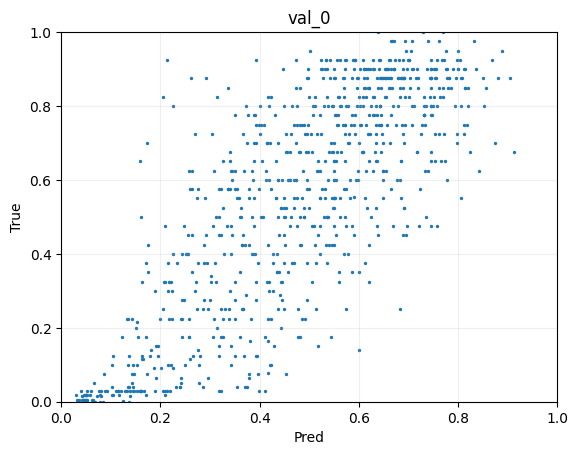

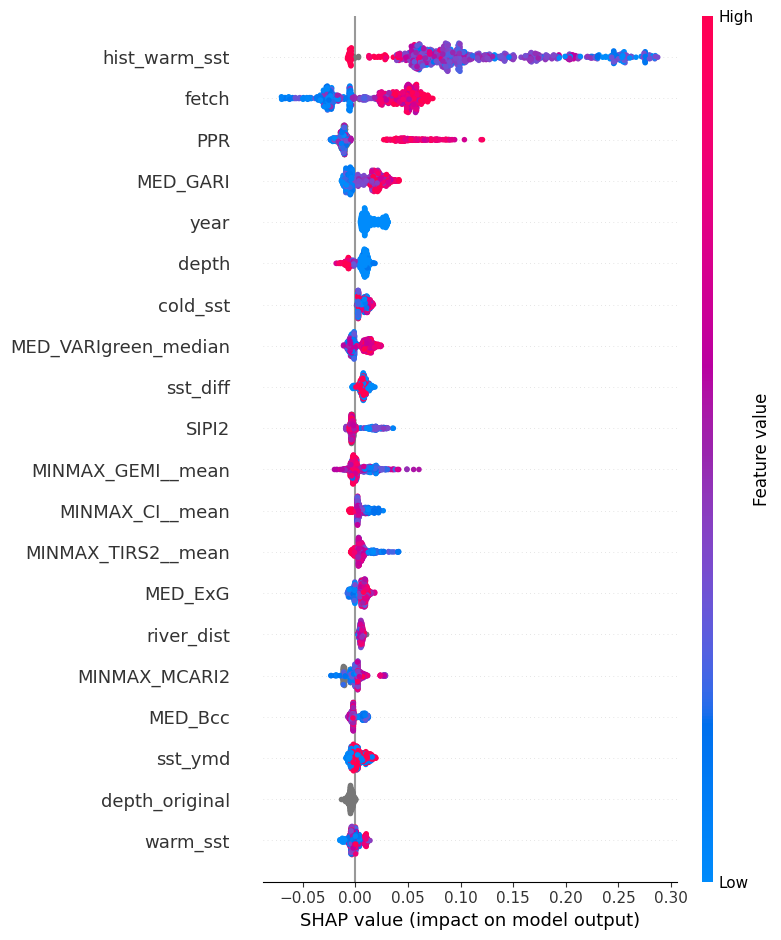

##############################
● CV1
##############################
[500]	valid_0's fair: 0.00372327
[1000]	valid_0's fair: 0.00362055
[1500]	valid_0's fair: 0.00355768
[2000]	valid_0's fair: 0.00357621
0.18769240050213018


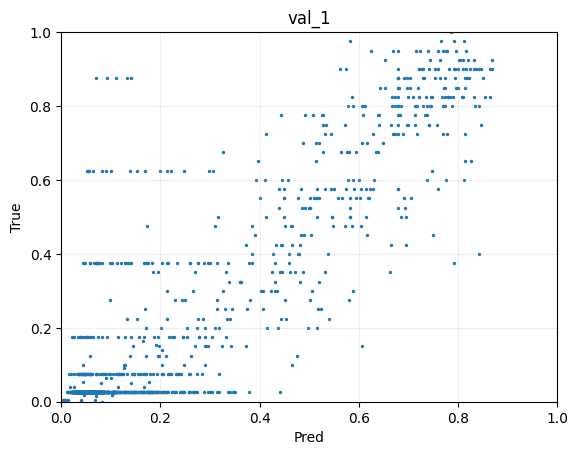

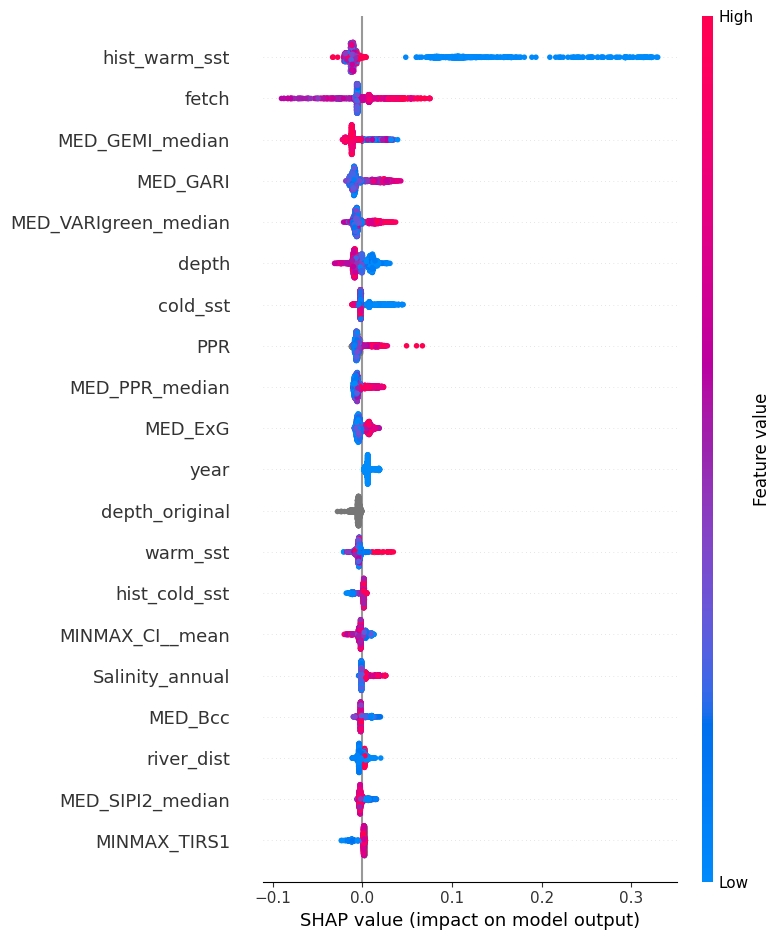

##############################
● CV2
##############################
[500]	valid_0's fair: 0.00214614
[1000]	valid_0's fair: 0.00219994
[1500]	valid_0's fair: 0.00217392
[2000]	valid_0's fair: 0.00219726
0.0814822583617848


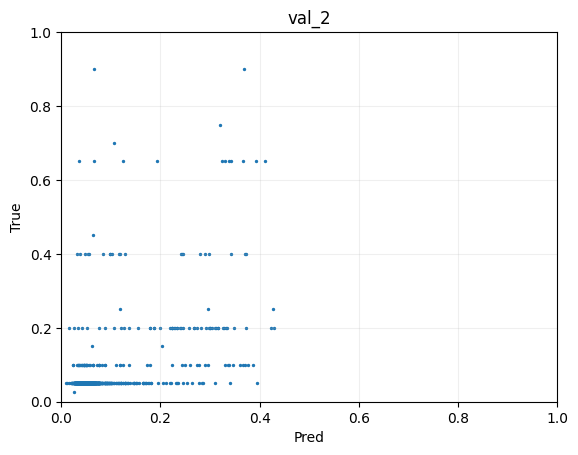

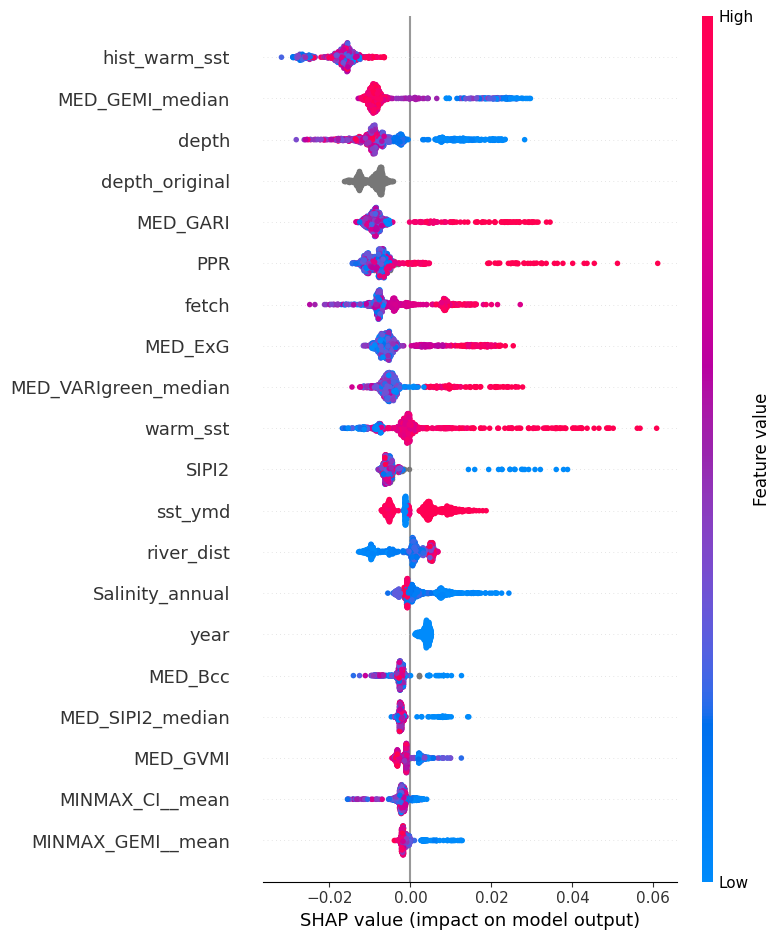

##############################
● CV3
##############################
[500]	valid_0's fair: 0.00196013
[1000]	valid_0's fair: 0.00238494
[1500]	valid_0's fair: 0.00259269
[2000]	valid_0's fair: 0.00267869
0.11924894388372427


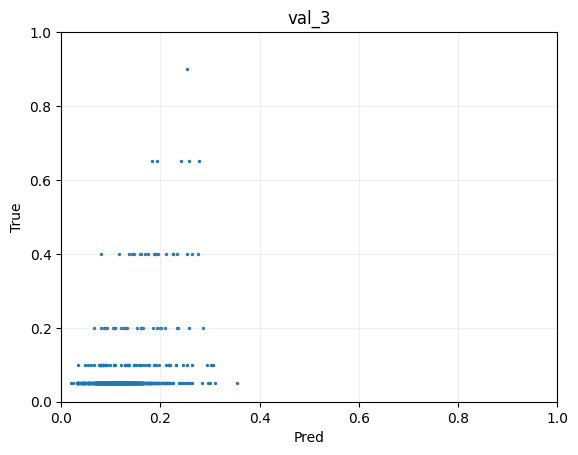

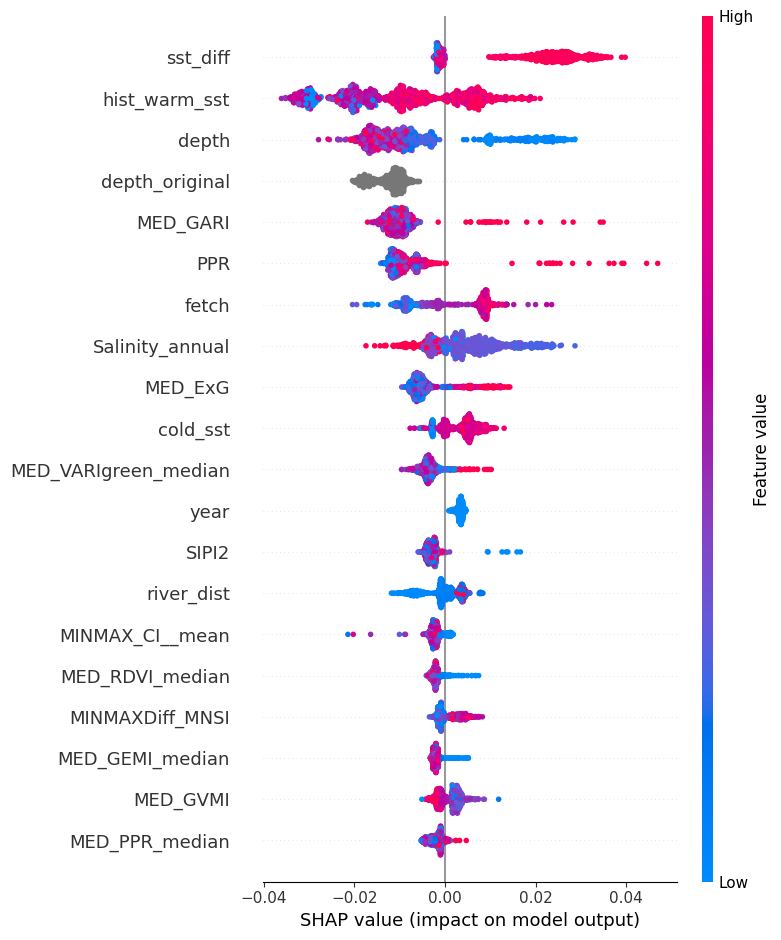

##############################
● CV4
##############################
[500]	valid_0's fair: 0.0189673
[1000]	valid_0's fair: 0.0191717
[1500]	valid_0's fair: 0.0194567
[2000]	valid_0's fair: 0.0195422
0.24707102046039592


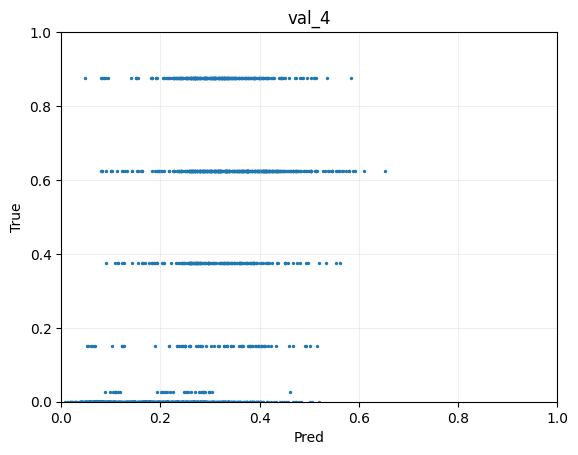

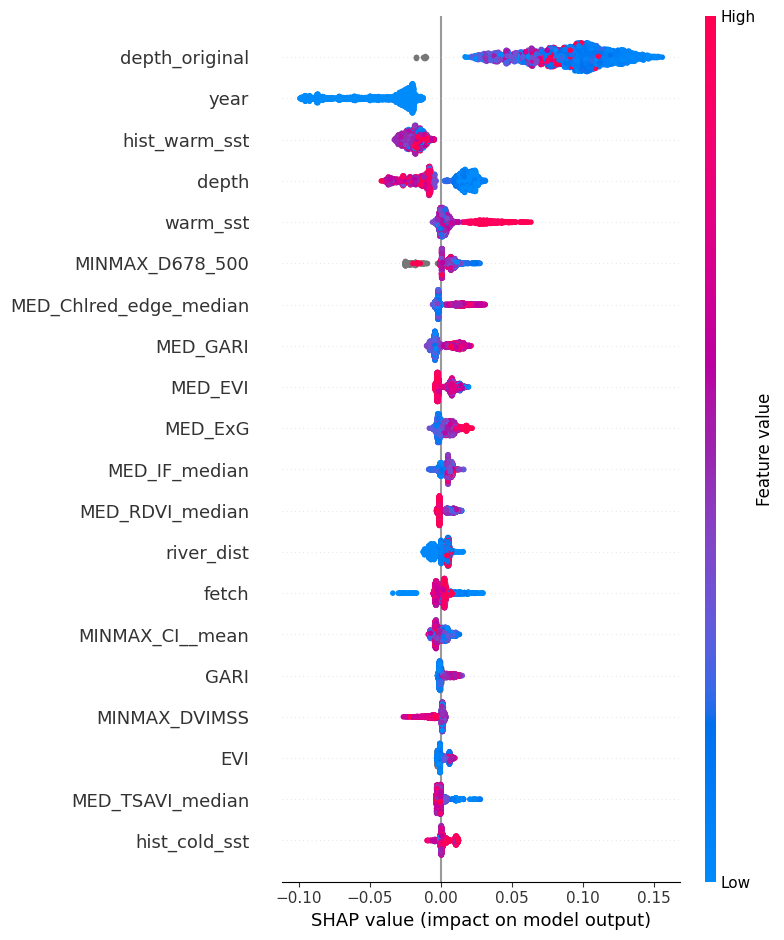

##############################
学習曲線
##############################


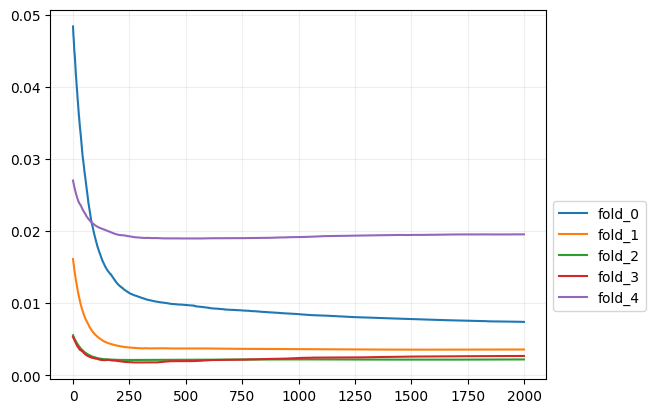

In [192]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'n_estimators': 2000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred, train["y_pred"] = my_cross_val_predict(train, test, y_name="log_cover", y_raw_name="cover", cv=cv, params=params, features=features)

CV0: 0.197
CV1: 0.119
CV2: 0.091
CV3: 0.089
CV4: 0.293
Average: 0.158


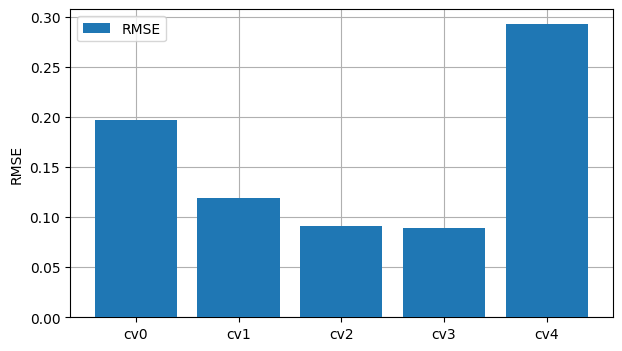

In [193]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 436)


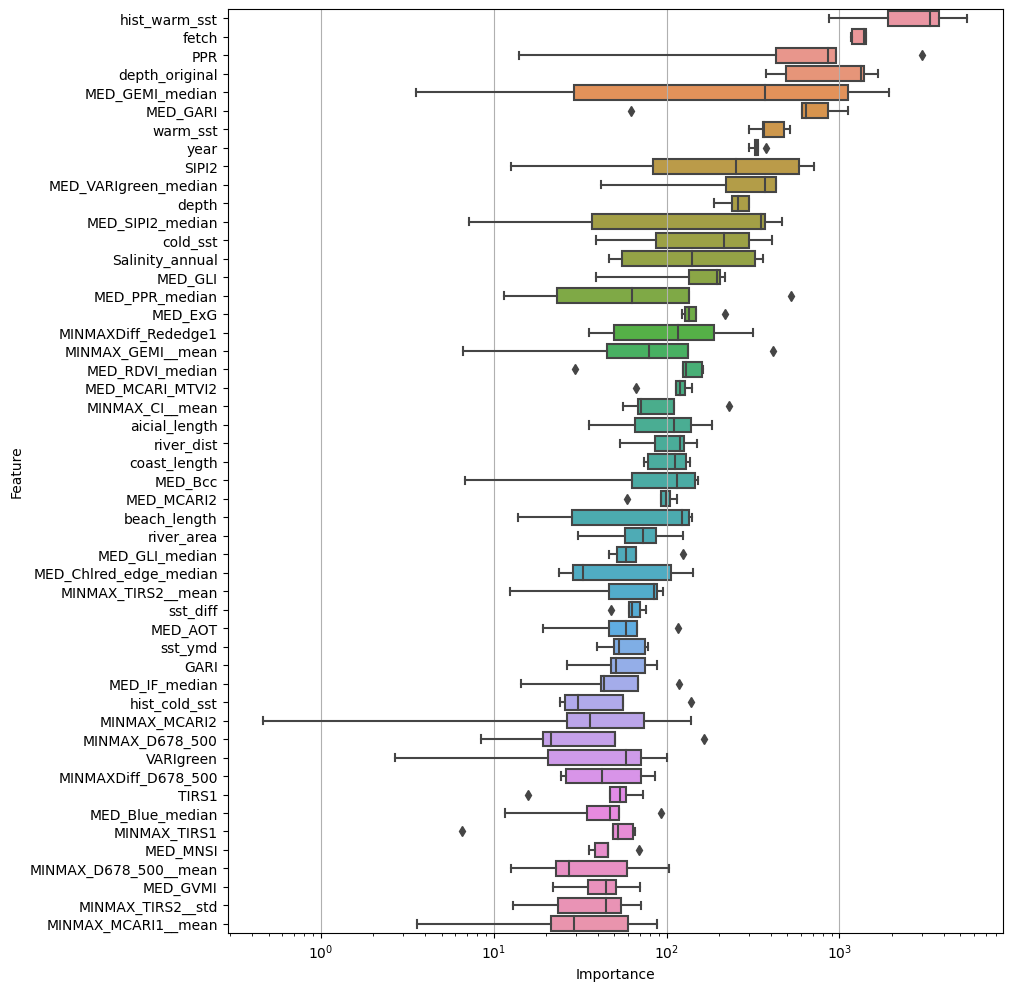

In [194]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [195]:
test_sub = pd.DataFrame(y_test_pred, columns=["pred"])
test_sub

,pred
0,0.120099
1,0.075184
2,0.215118
3,0.048760
4,0.129679
...,...
4034,0.100461
4035,0.051968
4036,0.266151
4037,0.084314


In [196]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.17236367709484773

In [197]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.038615
1,0.000000
2,0.133634
3,0.000000
4,0.048195
...,...
4034,0.018977
4035,0.000000
4036,0.184667
4037,0.002831


In [198]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.0
pred_最大値: 0.6810883078287058
pred_平均値: 0.17236367709484773


In [199]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.5996046307338581
pred_平均値: 0.10236400309238763


In [200]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)

# 予測結果確認

In [201]:
def check_by_scatter(check_col):
    tmp1 = df_pred[train[check_col].isnull()]
    tmp2 = df_pred[~train[check_col].isnull()]
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.grid(alpha=0.2, color="gray")
    ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"NOT Null", alpha=0.5)
    ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Null", alpha=0.5)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
    ax.set_title(check_col)
    ax.legend()
    plt.show()

In [202]:
df_pred = train[["cover", "y_pred"]]
score = np.sqrt(mean_squared_error(train['cover'].values, train['y_pred'].values))
print(f"全体のRMSE: {score:.04f}")

ValueError: ignored

In [ ]:
check_col = "depth_original"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "Blue"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "MED_AFRI1600"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "MAX_NormG__median"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "depth"
tmp1 = df_pred[train[check_col].isnull()]
tmp2 = df_pred[~train[check_col].isnull()]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}がnull)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}がnull以外)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}がnullの割合")
print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
check_by_scatter(check_col)

In [ ]:
check_col = "Landsat_num"
tmp1 = df_pred[train[check_col]==7]
tmp2 = df_pred[train[check_col]==8]
score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
print(f"●全体のRMSE ({check_col}==7)")
print(f"　データ数: {len(tmp1)}")
print(f"　スコア: {score1:.04f}\n")
print(f"●全体のRMSE ({check_col}==8)")
print(f"　データ数: {len(tmp2)}")
print(f"　スコア: {score2:.04f}\n")
print(f"テストデータで{check_col}==7の割合")
print(f"　{(100*(test[check_col]==7).sum()/len(test)):.3f}%")

fig, ax = plt.subplots(figsize=(7, 6))
ax.grid(alpha=0.2, color="gray")
ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"Landsat_num==8", alpha=0.5)
ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Landsat_num==7", alpha=0.5)
ax.set_xlabel("Pred")
ax.set_ylabel("True")
ax.set_title(check_col)
ax.legend()
plt.show()

In [ ]:
if SAVE_DF:
    train.to_pickle(SAVE_DF_DIR / f"train_predicted_{SUB_FILE_NAME}.pkl")